# Assignment 06: Transfer Learning

In [1]:
import torch 
from torchsummary import summary
import glob  # Import library for finding all files matching a pattern
from PIL import Image  # Import library for image processing
import numpy as np  # Import library for numerical operations (not used here)
import os  # Import library for operating system functionalities
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
from tqdm import tqdm
import scipy
import torch
from datetime import datetime, timedelta  # Import libraries for date and time manipulation
import torchvision
import torch.nn as nn
import torch.optim as optim  # Optimization algorithms for training the model
import torch.nn.functional as F  # Common loss functions and activation functions
from scipy.stats import spearmanr, pearsonr  # Statistical functions for correlation calculation
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training
import matplotlib.pyplot as plt  # Plotting library for visualization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the chosen device for training
print(device)


/home/omirako/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


## Data preparation

In [2]:
#download images
#!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
#download metadata
#!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar
#extract
#!tar -xf imdb_crop.tar
#!tar -xf imdb_meta.tar

#!mv imdb_meta ../datasets/imdb_meta
#!mv imdb_crop ../datasets/imdb_crop

#!rm imdb_crop.tar
#!rm imdb_meta.tar

Remove grayscale images

In [3]:
image_path_pattern = "../datasets/imdb_crop/*/*.jpg"
image_paths = glob.glob(image_path_pattern)


for image_path in image_paths:
    image = Image.open(image_path)
    num_channels = len(image.getbands())

    if num_channels != 3:
        os.remove(image_path)


Define function to convert numeric date to common date format

In [4]:
def datenum_to_datetime(datenum):
    try:
        days = datenum % 1  
        hours = days % 1 * 24  
        minutes = hours % 1 * 60  
        seconds = minutes % 1 * 60  

        exact_date = (datetime.fromordinal(int(datenum))  
                                 + timedelta(days=int(days))  
                                 + timedelta(hours=int(hours))  
                                 + timedelta(minutes=int(minutes))  
                                 + timedelta(seconds=round(seconds))) 
        exact_date -= timedelta(days=366)
        return exact_date.year

    except (ValueError, TypeError, OverflowError) as e:
        return np.nan 


Define the [dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) class

In [5]:
class FacesDataset(Dataset):

            def __init__(self, root_dir, transform, split):
                self.split=split
                self.root_dir = root_dir
                self.data = self.get_data() 
                len_data = self.data.shape[0]
                idx = np.arange(len_data)
                np.random.seed(0)
                np.random.shuffle(idx)

                # Select data based on split
                if split == "train":
                        self.data = self.data[idx[:int(len_data * 0.7)]]
                elif split == "val":
                        self.data = self.data[int(len_data * 0.7):int(len_data * 0.8)]
                else:
                        self.data = self.data[int(len_data * 0.8) : ]

                self.transform = transform



            def get_data(self):
                mat_imdb = scipy.io.loadmat('../datasets/imdb/imdb.mat')
                columns = ["full_path", "dob", "photo_taken", "second_face_score", "face_score"]

                # Convert loaded data into a dictionary
                data_dict = {col: mat_imdb['imdb'][0][0][col][0] for col in columns}
                df_imdb = pd.DataFrame(data_dict)

                # Convert date of birth to age using vectorized operations
                df_imdb['date_of_birth'] = df_imdb['dob'].apply(datenum_to_datetime)
                df_imdb['age'] = df_imdb['photo_taken'].sub(df_imdb['date_of_birth'])  # Handle potential NaNs

                # Filter images based on face score and presence of a single face
                df_imdb = df_imdb[df_imdb['face_score'] != -np.inf]  # Remove images without a face
                df_imdb = df_imdb[df_imdb['second_face_score'].isna()]  # Ensure only one face is present
                df_imdb = df_imdb[df_imdb['face_score'] >= 3.5]  # Filter based on minimum face score threshold
                df_imdb = df_imdb[(df_imdb['age'] <= 100) & (df_imdb['age'] >= 0)]  # Filter for valid age range
                df_imdb['age'] = df_imdb['age'].apply(lambda x: int(x))  # Convert age to integer
                df_imdb = df_imdb.drop(columns=['date_of_birth', 'dob', 'photo_taken', "second_face_score", "face_score"])  # Remove unnecessary columns
                df_imdb['full_path'] = self.root_dir+"/"+ df_imdb['full_path'].apply(lambda x: x[0]) # Construct full image paths using vectorized operations
                df_imdb = df_imdb[df_imdb['full_path'].apply(os.path.exists)] # Filter for images with existing paths using vectorized boolean indexing

                return df_imdb.to_numpy()  # Return preprocessed data as a NumPy array

            def load_data_into_ram(self):
                self.data_in_ram = []
                for img_name, age in self.data:
                    image = Image.open(os.path.join('', img_name))
                    image = self.transform(image)
                    age = age / 100
                    sample = {'image': image, 'age': torch.tensor(age).float()}
                    self.data_in_ram.append(sample)

            def __len__(self):
                return len(self.data)

            def __getitem__(self, idx):
                if hasattr(self, 'data_in_ram'):
                    return self.data_in_ram[idx]
                else:
                    img_name, age = self.data[idx]
                    image = Image.open(os.path.join('', img_name))
                    image = self.transform(image)
                    age = age / 100
                    sample = {'image': image, 'age': torch.tensor(age).float()}
                    return sample

## Create dataloaders




In [6]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize( 
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(), 
    transforms.Normalize(  
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Set batch size
bs = 128

trainset = FacesDataset("../datasets/imdb/imdb_crop", transform_train, split="train")
# trainset.load_data_into_ram() # maybe in another life
valset = FacesDataset("../datasets/imdb/imdb_crop", transform_val, split="val")
testset = FacesDataset("../datasets/imdb/imdb_crop", transform_val, split="rrffrfr")

In [7]:
len(trainset), len(valset), len(testset)

(50279, 7183, 14366)

## Define a Neural Network (NN)
[Mobilenet](https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v2.html#torchvision.models.mobilenet_v2) pretrained on Imagenet.


Replace the last classifier

## **Transfer learning**

Train only the last layers

In [8]:
# Adjust the final classification layer


def transfer_learning(net, new_classifier, name, freeze = True):
    
    old_classifier = getattr(net, name)
    
    if isinstance(old_classifier, nn.Sequential):
        new_classifier[0] = nn.Linear(old_classifier[0].in_features, new_classifier[0].out_features)
    else:
        new_classifier[0] = nn.Linear(old_classifier.in_features, new_classifier[0].out_features)
        
    setattr(net, name, new_classifier)


    # Freeze pre-trained layers and unfreeze the classifier for fine-tuning
    if freeze:
        for key, value in dict(net.named_children()).items():
            if name in key:
                for param in value.parameters():
                    param.requires_grad = True
                    print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
            else:
                for param in value.parameters():
                    param.requires_grad = False
                    print(f"Freezing layer: {key}, Parameter shape: {param.shape}")
    return net

In [9]:

#net = torchvision.models.resnet50(weights="IMAGENET1K_V2")
#net = torchvision.models.wide_resnet101_2(weights="IMAGENET1K_V2")
#net = torchvision.models.regnet_y_128gf(weights="IMAGENET1K_SWAG_E2E_V1")
#net = torchvision.models.mobilenet_v3_large(weights="IMAGENET1K_V2", pretrained=True, progress=True)
#net = torchvision.models.resnet152(weights="IMAGENET1K_V2", progress=True)

net = torchvision.models.resnet18(weights="DEFAULT", progress=True)

torch.save(net.state_dict(), f'../datasets/imdb/{net.__class__.__name__}.pth')
name = "fc"


new_classifier = nn.Sequential(
    nn.Linear(0, 512),  # First linear layer with 512 units
    nn.GELU(),  # GELU activation function
    nn.Linear(512, 256),  # Second linear layer with 32 units
    nn.GELU(),  # GELU activation function
    nn.Linear(256, 32),   # Output layer with 1 unit (for age prediction)
    nn.GELU(),  # GELU activation function
    nn.Linear(32, 1)  # Output layer with 1 unit (for age prediction)
)



'''
new_classifier = nn.Sequential(
    nn.Linear(0, 2048),  
    nn.GELU(),
    nn.Linear(2048, 512),
    nn.GELU(),
    nn.Linear(512, 128),
    nn.GELU(),
    nn.Linear(128, 1)  
)

new_classifier = nn.Sequential(
    nn.Linear(0, 512),  # First linear layer with 512 units
    nn.GELU(),
    nn.Linear(512, 256),
    nn.GELU(),
    nn.Linear(256, 1)  # Final linear layer with 1 unit (regression output)
)
'''
net = transfer_learning(net, new_classifier, name, freeze = True)
net.to(device)
# Print model summary
summary(net, (3, 256, 256))  # Input shape (channels, height, width)

/home/omirako/.local/lib/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

## **Fine-tuning**

Train the network on the training data performing a validation at the end of each epoch. The evaluation is done using [PLCC](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [SROCC](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)

In [10]:
def evaluate(net, dataloader, train, criterion, optimizer, scheduler):
    try:
        pbar.close()
    except:
        pass

    gt_labels = []
    pr_labels = []
    running_loss = []
    plcc_values = []
    srocc_values = []
    tot_labels = []
    tot_preds = []

    pbar = tqdm(total=len(dataloader), desc=f"{'Train' if train else 'Validation'}", leave=True)
    for data in dataloader:
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.cpu().numpy())
        inputs, labels = inputs.to(device), labels.to(device)

        if train:
            outputs = net(inputs)
        else:
            with torch.no_grad():
                outputs = net(inputs)

        loss = criterion(outputs.squeeze(), labels)
        pr_labels.append(outputs.squeeze().detach().cpu())
        running_loss.append(loss.item())

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

        gt_labels_batch = np.stack(gt_labels).squeeze()
        pr_labels_batch = np.stack(pr_labels).squeeze()
        tot_labels.append(gt_labels_batch)
        tot_preds.append(pr_labels_batch)
        srocc_values.append(spearmanr(gt_labels_batch, pr_labels_batch)[0])
        plcc_values.append(pearsonr(gt_labels_batch, pr_labels_batch)[0])

        gt_labels = []
        pr_labels = []

        pbar.set_description(f"{'Train' if train else 'Validation'} Loss: {np.mean(running_loss):.6f}, PLCC: {np.mean(plcc_values):.3f}, SROCC: {np.mean(srocc_values):.3f}")
        pbar.update(1)

    pbar.close()
    return np.concatenate(tot_preds), np.concatenate(tot_labels)



def train(net, trainloader, valloader, epochs, criterion, optimizer, scheduler, continue_training=''):
    previous_epoch = 0  # Initialize previous_epoch to 0

    try:
        print(f"Found best model, calculating SROCC...")
        
        checkpoint = torch.load('../datasets/imdb/best_model.pth')
        best_model = checkpoint['model']
        best_criterion = checkpoint['loss']
        best_scheduler = checkpoint['scheduler']
        best_optimizer = checkpoint['optimizer']
        best_model.load_state_dict(checkpoint['model_state_dict'])
        best_criterion.load_state_dict(checkpoint['criterion_state_dict'])
        best_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        gt_labels, pr_labels = evaluate(net=best_model, dataloader=valloader, train=False, criterion=best_criterion, optimizer=best_optimizer, scheduler=best_scheduler)
        best_srocc = spearmanr(gt_labels, pr_labels)[0]
        print(f"SROCC best model: {best_srocc:.3f}")
        del best_model, best_optimizer, best_criterion, best_scheduler, checkpoint, gt_labels, pr_labels
    except Exception as e:
        best_srocc = -1
        print(e)
        print("No best model found, starting from scratch")

    if continue_training != '':
        try:
            checkpoint = torch.load(f'../datasets/imdb/net_{continue_training}.pth')
            net = checkpoint['model']
            criterion = checkpoint['loss']
            scheduler = checkpoint['scheduler']
            optimizer = checkpoint['optimizer']
            net.load_state_dict(checkpoint['model_state_dict'])
            criterion.load_state_dict(checkpoint['criterion_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            previous_epoch = checkpoint['epoch']  # Update previous_epoch
            epochs += previous_epoch  # Update total number of epochs to train
            
            del checkpoint
            print(f"Continuing training of {continue_training} model, checkpoint at epoch {previous_epoch}")
        except Exception as e:
            print(e)
            print(f"No {continue_training} checkpoint found, starting from scratch")

    for epoch in range(previous_epoch, epochs):  # Loop over the dataset for multiple epochs
        print(f"Epoch {epoch}/{epochs}: ")
        
        net.train()  # Set model to training mode
        evaluate(net=net,
                dataloader=trainloader,
                train=True,
                criterion=criterion,
                optimizer=optimizer,
                scheduler=scheduler)
        
        net.eval()  # Set model to evaluation mode
        pr_labels, gt_labels = evaluate(net = net,
                                        dataloader = valloader,
                                        train=False,
                                        criterion=criterion,
                                        optimizer=optimizer,
                                        scheduler=scheduler)

        # Visualization (optional)
        sp = spearmanr(gt_labels, pr_labels)[0]
        pe = pearsonr(gt_labels, pr_labels)[0]
        
        plt.scatter(pr_labels, gt_labels)
        plt.xlabel("AGE Predicted")
        plt.ylabel("AGE GT")
        plt.title("PLCC: %.3f\nSROCC: %.3f" % (pe, sp))
        plt.show()

        if sp > best_srocc:
            best_srocc = sp
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'criterion_state_dict': criterion.state_dict(),
                'model' : net,
                'loss': criterion,
                'optimizer': optimizer,
                'scheduler': scheduler,
                }, '../datasets/imdb/net_best.pth')
            print(f"New best model saved with SROCC: {sp:.3f}")
            
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'criterion_state_dict': criterion.state_dict(),
            'model' : net,
            'loss': criterion,
            'optimizer': optimizer,
            'scheduler': scheduler,
            }, f'../datasets/imdb/net_last.pth')

In [11]:
bs = 512
epochs = 50
num_workers = 8

trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=num_workers)
valloader = torch.utils.data.DataLoader(valset, batch_size=bs, shuffle=False, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=num_workers)

criterion = nn.L1Loss()  
optimizer = optim.Adam(net.parameters(), lr=0.0001)  
scheduler = CosineAnnealingLR(optimizer, T_max=len(trainloader) * epochs, eta_min=1e-5)  

Found best model, calculating SROCC...


Validation Loss: 0.055434, PLCC: 0.729, SROCC: 0.695: 100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


SROCC best model: 0.756
Epoch 0/50: 


Train Loss: 0.070036, PLCC: 0.693, SROCC: 0.650: 100%|██████████| 99/99 [00:51<00:00,  1.91it/s]
Validation Loss: 0.062147, PLCC: 0.717, SROCC: 0.670: 100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


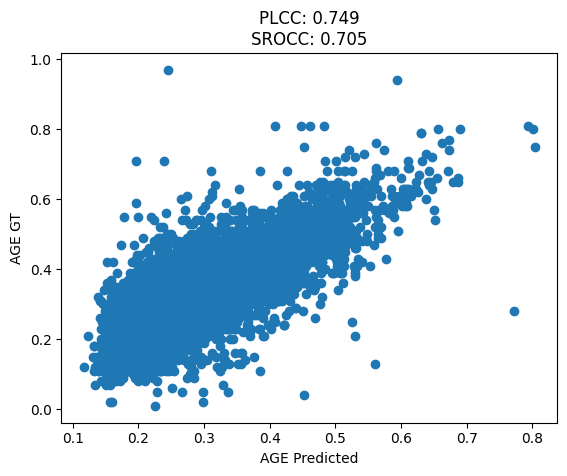

Epoch 1/50: 


Train Loss: 0.055412, PLCC: 0.810, SROCC: 0.779: 100%|██████████| 99/99 [00:51<00:00,  1.92it/s]
Validation Loss: 0.048638, PLCC: 0.768, SROCC: 0.742: 100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


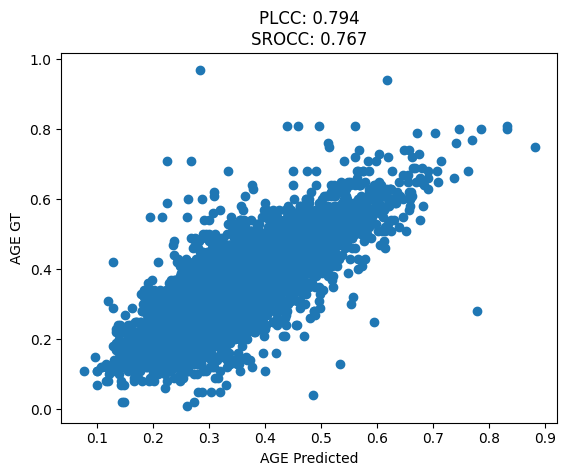

New best model saved with SROCC: 0.767
Epoch 2/50: 


Train Loss: 0.051252, PLCC: 0.835, SROCC: 0.808: 100%|██████████| 99/99 [00:51<00:00,  1.93it/s]
Validation Loss: 0.047384, PLCC: 0.785, SROCC: 0.755: 100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


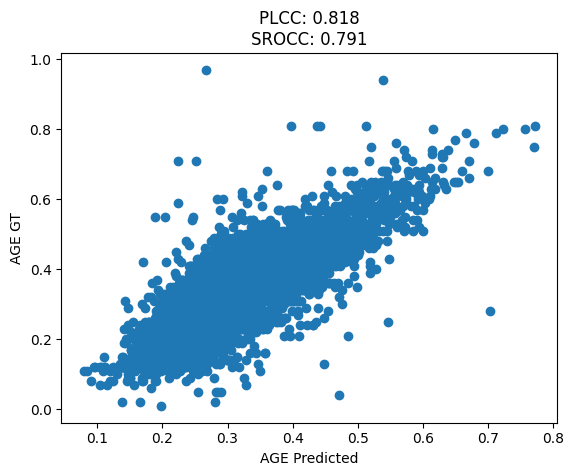

New best model saved with SROCC: 0.791
Epoch 3/50: 


Train Loss: 0.049280, PLCC: 0.849, SROCC: 0.823: 100%|██████████| 99/99 [00:51<00:00,  1.92it/s]
Validation Loss: 0.046598, PLCC: 0.791, SROCC: 0.757: 100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


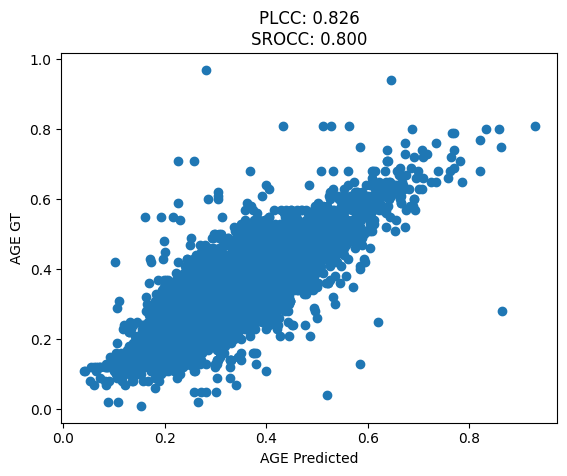

New best model saved with SROCC: 0.800
Epoch 4/50: 


Train Loss: 0.047722, PLCC: 0.856, SROCC: 0.831:  34%|███▍      | 34/99 [00:19<00:31,  2.04it/s]

KeyboardInterrupt: 

In [12]:
train(net, trainloader, valloader, epochs, criterion, optimizer, scheduler, continue_training='')

## Evaluate on the test-set



















































































































Validation Loss: 0.025866, PLCC: 0.920, SROCC: 0.900: 100%|██████████| 57/57 [00:08<00:00,  6.88it/s]


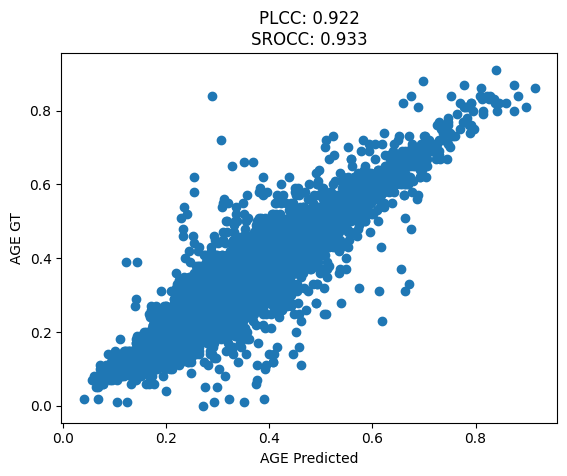

In [ ]:
net.eval()

pr_labels, gt_labels = evaluate(net, testloader, train=False, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

plt.scatter(pr_labels, gt_labels)
plt.xlabel("AGE Predicted")
plt.ylabel("AGE GT")
plt.title("PLCC: %.3f\nSROCC: %.3f" % (spearmanr(gt_labels, pr_labels)[0], pearsonr(gt_labels, pr_labels)[0]))
plt.show()


In [ ]:
checkpoint = torch.load(f'../datasets/imdb/net_best.pth')
net = checkpoint['model']
criterion = checkpoint['loss']
scheduler = checkpoint['scheduler']
optimizer = checkpoint['optimizer']
net.load_state_dict(checkpoint['model_state_dict'])
criterion.load_state_dict(checkpoint['criterion_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
img = Image.open("../datasets/imdb/image copy 17.png")
# convert img to a sensible format for my network
img = transform_val(img).unsqueeze(0)
# move to device
img = img.to(device)
net.eval()
output = net(img)
# remove normalization:
output = output * 100
output = output.detach().cpu().numpy()
print(output)

[[62.835564]]


**!ASSIGNMENT!**

*Transfer learning*
1. Finetune all the layers of the current network (mobilenet_v2).
2. Swap out the current model with a new one from [here](https://pytorch.org/vision/main/models.html#classification) that is already trained on Imagenet. Then, fine-tune the network and compare how well it performs on the test-set compared to the current network (mobilenet_v2) using PLCC and SROCC metrics.